## Специализированные программные библиотеки для анализа данных.

### Импортируем необходимые модули 

In [352]:
import numpy as np
import scipy, datetime
import pandas as pd
import matplotlib.pyplot as plt # библиотека для построения графиков
import matplotlib.ticker as mticker
import seaborn as sns # библиотека для построения графиков
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#sns.set()
# с помощью этой строки мы можем включать в этот документ графики:
%matplotlib inline 

## Шперлинг Софья 21151


##### Разминка

In [353]:
from sklearn.decomposition import PCA
from sklearn.datasets import *

## Загрузите игрушечный набор -- ирисы
iris = load_iris()
X = iris.data
y = iris.target

In [354]:
## создадим датафрейм
df = pd.DataFrame(iris.data.T, index = iris.feature_names).T

In [355]:
## посмотрите на ваши данные
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


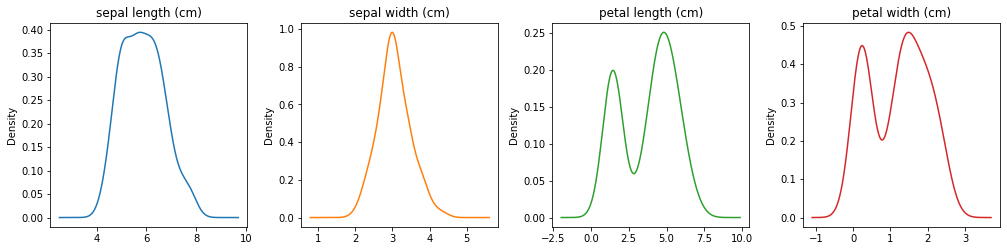

In [356]:
## изобразите распределение значений параметров вашего набора
## например, в виде графиков
_ = df.plot(kind='kde', subplots=True, layout=(4,4), sharex=False,
                         sharey=False, figsize=[14,13], legend = False,
                         title = df.columns.values.tolist())
plt.tight_layout();


##### Визуализация результатов PCA

(4, 4) (4,) (4, 4)
[2.93808505 0.9201649  0.14774182 0.02085386]
[2.93808505 0.9201649 ]


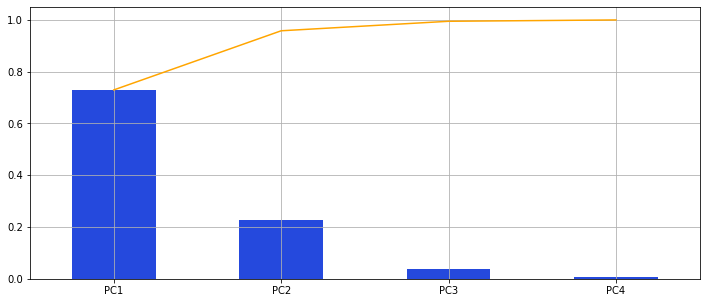

In [357]:
## проведите анализ PCA
from sklearn.preprocessing import StandardScaler

Xsc = StandardScaler().fit_transform(X.astype('float64'))
Xsc = pd.DataFrame(Xsc, index=df.index, columns=df.columns)
pca = PCA(n_components=2)

mean_vec = np.mean(Xsc.values, axis=0)
# посчитаем ковариационную матрицу
cov_mat = (Xsc - mean_vec).T.dot((Xsc - mean_vec)) / (Xsc.shape[0] - 1)
# разложим ковариационную матрицу на собственные числа и собственные вектора
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

# используя SVD разложение получим левые сингулярные вектора, сингулярные значения и правые сингулярные вектора
u,s,v = np.linalg.svd(cov_mat)
print(u.shape, s.shape, v.shape)

# сингулярные числа, полученные при разложении ковариационной матрицы
print(s)
# построим PCA модель
skpcamod = pca.fit(X = Xsc)
# выведем значения объясненной дисперсии для каждого из главных компонент
# (заметим, что они совпадают с сингулярные числа, полученные при разложении ковариационной матрицы)
print(skpcamod.explained_variance_ )

# построим график доли дисперсии, объясненной каждым ГК,
# а так же суммарной доля дисперсии, объясненная k главными компонентами.


pd.Series(s/s.sum(),
          index = [f'PC{x+1}' for x in range(Xsc.shape[1])]).plot.bar( color = '#2549dd', figsize = (12, 5));
pd.Series((s/s.sum()).cumsum(),
          index = [f'PC{x+1}' for x in range(Xsc.shape[1])]).plot( color = 'orange');
plt.grid();

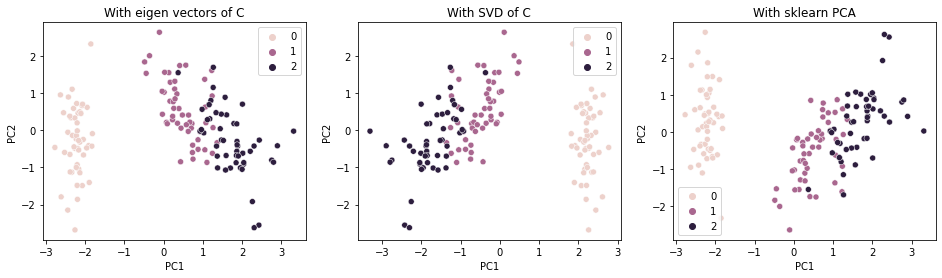

In [358]:
## постройте диаграмму рассеяния в координатах PC1, PC2
## цвет точек должен соответствовать целевой переменной - y - один из 3 видов ирисов

#отсортируем по убыванию собственные значения
ixs = np.argsort(eig_vals)[::-1]

scores_eig = pd.DataFrame(Xsc @ eig_vecs[:,ixs][:,:2])
scores_svd = pd.DataFrame(Xsc @ u[:,:2])
scores_skl = pd.DataFrame(skpcamod.transform(Xsc)[:,:2])
scores_svd.columns = ['PC1','PC2']
scores_eig.columns = ['PC1','PC2']
scores_skl.columns = ['PC1','PC2']

_ , axes = plt.subplots(ncols=3, nrows=1, figsize = (16, 4))
sns.scatterplot(x = 'PC1', y = 'PC2', data = scores_eig, hue = y, ax = axes[0])
sns.scatterplot(x = 'PC1', y = 'PC2', data = scores_svd, hue = y, ax = axes[1])
sns.scatterplot(x = 'PC1', y = 'PC2', data = scores_skl, hue = y, ax = axes[2])
axes[0].set_title('With eigen vectors of C')
axes[1].set_title('With SVD of C')
axes[2].set_title('With sklearn PCA');


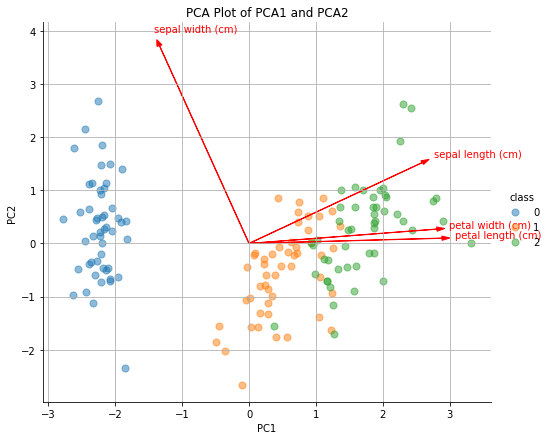

In [359]:
## постройте биплот, отражающий влияние исходных параметров на PC1 и PC2
sklearn_pca = PCA(n_components=2)

sklearn_transf = pd.DataFrame(sklearn_pca.fit_transform(Xsc), # проводим МГК стандартизованных данных
                              columns = ['PC1','PC2'])

Y = pd.Series(y)
df_pca = pd.DataFrame(sklearn_transf)
df_pca = pd.concat([Y, df_pca], axis = 1)
df_pca.columns = ['class','PC1', 'PC2']

sns.lmplot(x = 'PC1', y = 'PC2', data=df_pca, fit_reg = False,
           hue = 'class', height = 6, aspect = 7/6, scatter_kws={"s": 50, 'alpha':0.5})

xvector = sklearn_pca.components_[0]
yvector = sklearn_pca.components_[1]

for i in range(len(xvector)):
    plt.arrow(0, 0, xvector[i]*df_pca.PC1.max()*1.5, yvector[i]*df_pca.PC2.max()*1.5,
              color='r', width=0.005, head_width=0.08)
    plt.text(xvector[i]*df_pca.PC1.max()*1.6, yvector[i]*df_pca.PC2.max()*1.6,
             list(df.columns.values)[i], color='r')
plt.grid()
_ = plt.title('PCA Plot of PCA1 and PCA2')

##### Набор данных -- уже не столь свежая сводка по эпидемиологической обстановке в России

In [360]:
#ncov_ru_j = # прочитайте данные из файла, который вы создали на прошлом занятии
## В вашей таблице должны быть колонки:
## "Активных" - число активных случаев = 'Заражений' - 'Выздоровлений' - 'Смертей'
## "Активных на 100К населения"
## "Заражений на 100К населения"
## "Смертей на 100К населения"
## "Заражений за день на 100К населения"
## "Смертей за день на 100К населения"

## Проверьте, что колонка "Дата" относится к типу "datetime64", если нет -- преобразуйте
## В качестве индексов используйте колонки "Регион" и "Дата"


ncov_ru_de = pd.read_csv('COVID_RU_Ya_descr.csv')
ncov_ru_stat =pd.read_csv('COVID_RU_Ya_stat.csv')
ncov_ru_j = pd.merge(ncov_ru_de, ncov_ru_stat, on=('Регион'))
ncov_ru_j['Дата'] = pd.to_datetime(ncov_ru_j['Дата'], dayfirst=True)
ncov_ru_j.set_index(['Регион','Дата'], inplace = True)
ncov_ru_j['Активных'] = ncov_ru_j['Заражений'] - ncov_ru_j['Смертей'] - ncov_ru_j['Выздоровлений']
ncov_ru_j['Активных на 100К населения'] = ncov_ru_j['Активных'] / (ncov_ru_j['Регион население']/100000)
ncov_ru_j['Заражений на 100К населения'] = ncov_ru_j['Заражений'] / (ncov_ru_j['Регион население']/100000)
ncov_ru_j['Смертей на 100К населения'] = ncov_ru_j['Смертей'] / (ncov_ru_j['Регион население']/100000)
ncov_ru_j['Заражений за день на 100К населения'] = ncov_ru_j['Заражений за день'] / (ncov_ru_j['Регион население']/100000)
ncov_ru_j['Смертей за день на 100К населения'] = ncov_ru_j['Смертей за день'] / (ncov_ru_j['Регион население']/100000)
ncov_ru_j.head()


Unnamed: 0_x                                 ФО  \
Регион        Дата                                                          
Амурская обл. 2020-03-13             0  Дальневосточный федеральный округ   
              2020-03-14             0  Дальневосточный федеральный округ   
              2020-03-15             0  Дальневосточный федеральный округ   
              2020-03-16             0  Дальневосточный федеральный округ   
              2020-03-17             0  Дальневосточный федеральный округ   

                           Регион название  Регион население  Unnamed: 0_y  \
Регион        Дата                                                           
Амурская обл. 2020-03-13  Амурская область            798424            82   
              2020-03-14  Амурская область            798424           164   
              2020-03-15  Амурская область            798424           246   
              2020-03-16  Амурская область            798424           328   
              2020-03-17  Амурская область            798424           410   

                          Заражений  Выздоровлений  Смертей  Смертей за день  \
Регион        Дата                                                             
Амурская обл. 2020-03-13          0              0        0                0   
              2020-03-14          0              0        0                0   
              2020-03-15          0              0        0                0   
              2020-03-16          0              0        0                0   
              2020-03-17          0              0        0                0   

                          Заражений за день  Выздоровлений за день  \
Регион        Дата                                                   
Амурская обл. 2020-03-13                  0                      0   
              2020-03-14                  0                      0   
              2020-03-15                  0                      0   
              2020-03-16                  0                      0   
              2020-03-17                  0                      0   

                          Летальность, %  Активных  \
Регион        Дата                                   
Амурская обл. 2020-03-13             NaN         0   
              2020-03-14             NaN         0   
              2020-03-15             NaN         0   
              2020-03-16             NaN         0   
              2020-03-17             NaN         0   

                          Активных на 100К населения  \
Регион        Дата                                     
Амурская обл. 2020-03-13                         0.0   
              2020-03-14                         0.0   
              2020-03-15                         0.0   
              2020-03-16                         0.0   
              2020-03-17                         0.0   

                          Заражений на 100К населения  \
Регион        Дата                                      
Амурская обл. 2020-03-13                          0.0   
              2020-03-14                          0.0   
              2020-03-15                          0.0   
              2020-03-16                          0.0   
              2020-03-17                          0.0   

                          Смертей на 100К населения  \
Регион        Дата                                    
Амурская обл. 2020-03-13                        0.0   
              2020-03-14                        0.0   
              2020-03-15                        0.0   
              2020-03-16                        0.0   
              2020-03-17                        0.0   

                          Заражений за день на 100К населения  \
Регион        Дата                                              
Амурская обл. 2020-03-13                                  0.0   
              2020-03-14                                  0.0   
              2020-03-15                                  0.0   
    

In [361]:
## определите прирост числа заражений в процентах за неделю -- как вы это сделаете вопрос

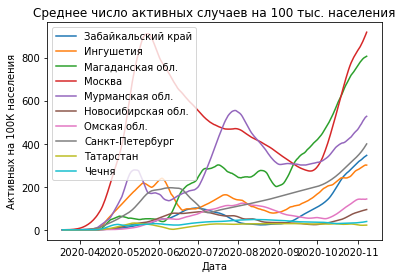

In [362]:
## если не получится -- просто постройте графики среднего числа активных случаев
## на 100 тыс. населения со скользящим окном в 7 дней
## пример, как посчитать был на предыдущих занятиях -- ближе к концу в ноутбуке №2
## постройте график для следующих регионов:
regs = ['Забайкальский край', 'Ингушетия', 'Магаданская обл.', 'Москва', 'Мурманская обл.',
        'Новосибирская обл.', 'Омская обл.', 'Санкт-Петербург', 'Татарстан', 'Чечня']
## на самом деле смысла в выборе именно этих регионов нет -- можете выбрать другие какие вам нравятся.
## Просто если мы сразу отрисуем все регионы на одном графике -- он получится нечитаемым

for region in regs:
    plt.plot(ncov_ru_j.loc[[region,]]['Активных на 100К населения'].unstack().T.rolling(7).mean(), label = region)
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Активных на 100К населения')
plt.title('Среднее число активных случаев на 100 тыс. населения')
plt.show()

In [363]:
ncov_ru_j.reset_index(inplace=True)

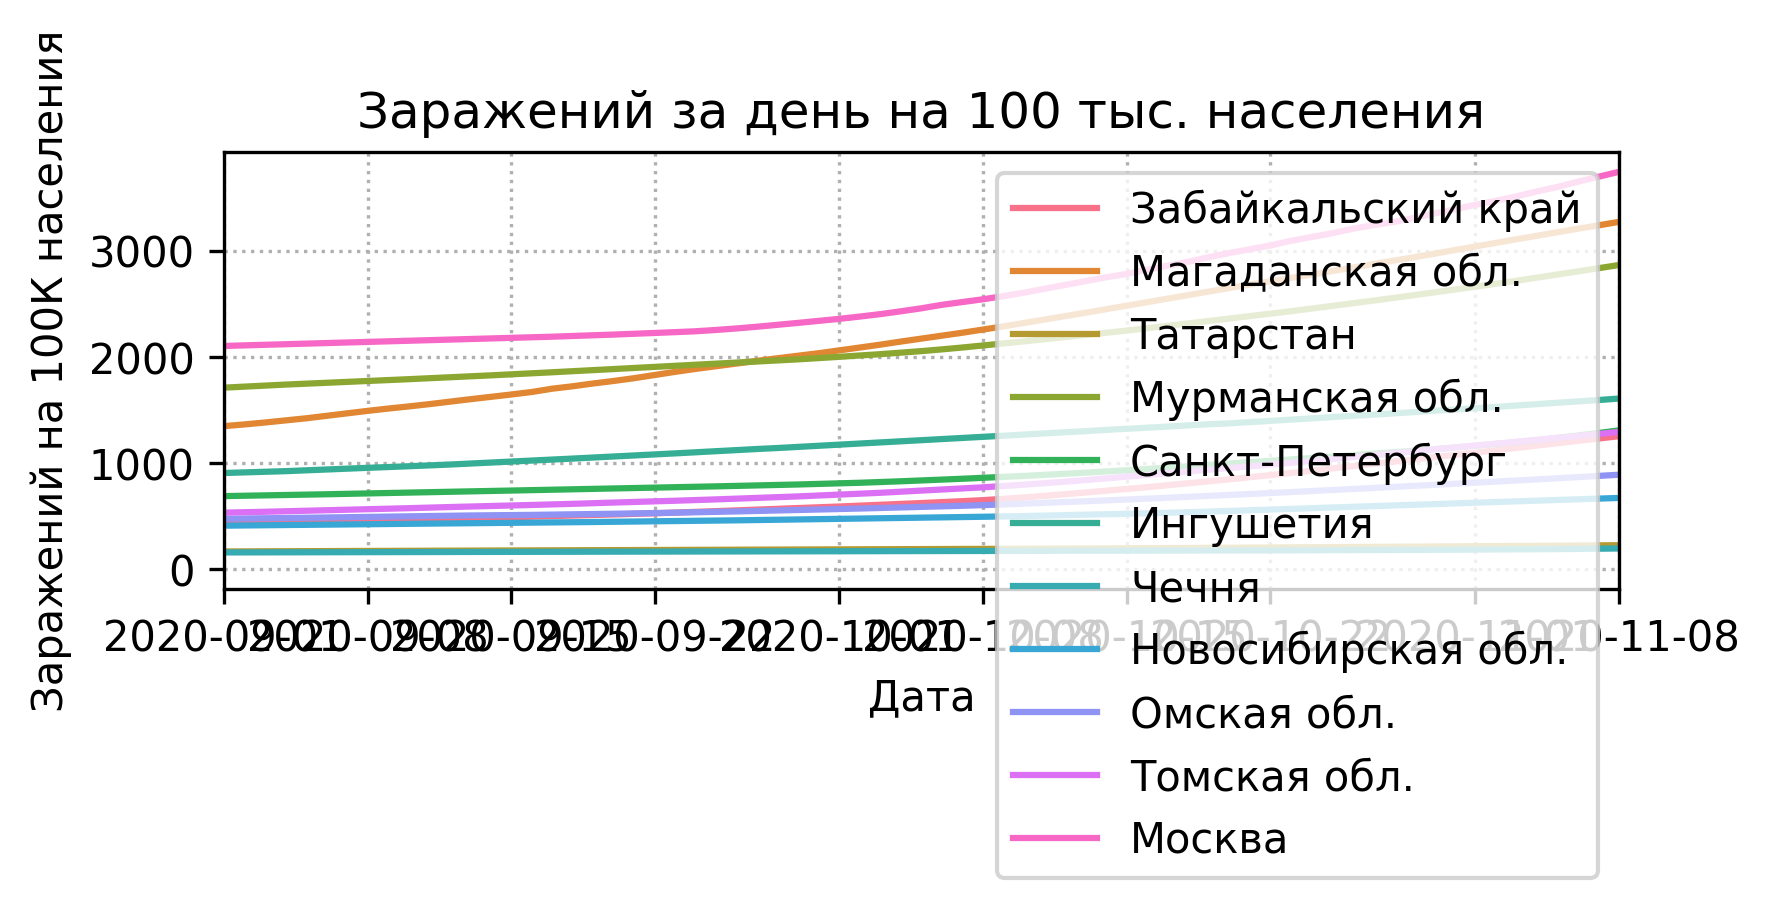

In [364]:
## Постройте график изменения прироста числа заражений начиная с сентября
## с помощью sns.lineplot  
## создаете figure и axes, задаете размер фигуры и разрешение:
ncov_ru_j_cut =ncov_ru_j[ncov_ru_j['Регион']=='Томская обл.']
for region in regs:
    ncov_ru_j_cut = ncov_ru_j_cut.append(ncov_ru_j[ncov_ru_j['Регион']==region])
fig, ax = plt.subplots(figsize = [6, 2.5], dpi = 300) ## например так
sns.lineplot( data = ncov_ru_j_cut,
                  x = 'Дата',
                  y = ncov_ru_j['Заражений на 100К населения'],
                  hue= 'Регион',
                  ax = ax)
ax.set_title('Заражений за день на 100 тыс. населения')
ax.grid(ls =':')
plt.legend()
## Если вы считаете, что данные лучше смотреть в логарифмической шкале, можете раскомментировать код, приведенный ниже
#ax.set_xscale('log', base=10);
#ax.set_yscale('log', base=10);
## Помним про необходимость установить временные границы
ax.set_xlim([pd.to_datetime('2020-09-01'), ncov_ru_j['Дата'][-1:]])
plt.tight_layout()
plt.show()

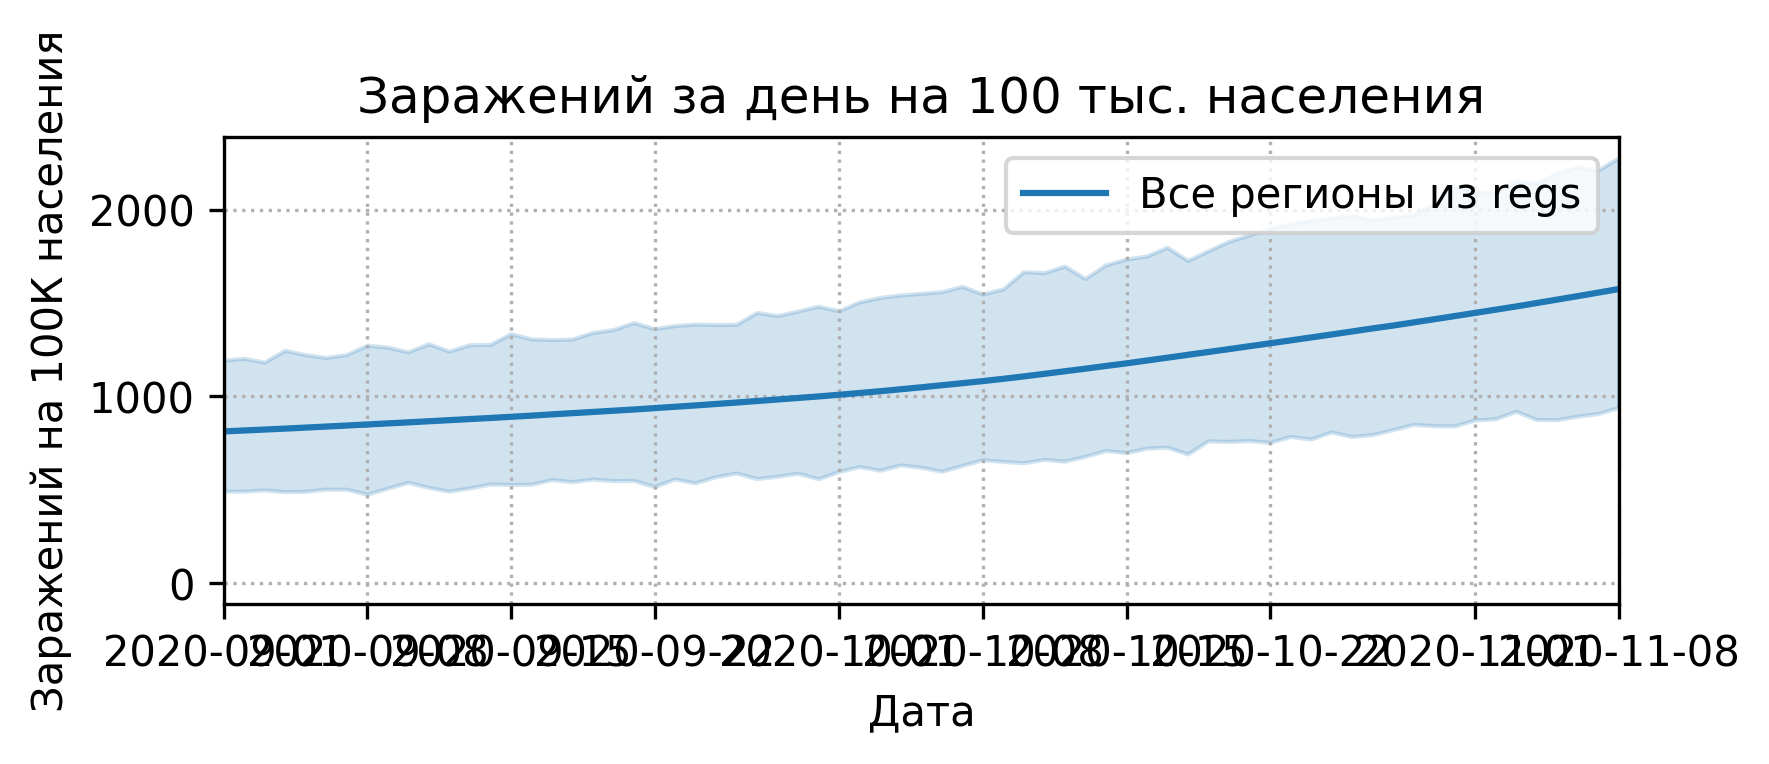

In [368]:
fig, ax = plt.subplots(figsize = [6, 2.5], dpi = 300) ## например так
sns.lineplot( data = ncov_ru_j_cut,
                  x = 'Дата',
                  y = ncov_ru_j['Заражений на 100К населения'],
                  label = 'Все регионы из regs',
                  ax = ax)
ax.set_title('Заражений за день на 100 тыс. населения')
ax.grid(ls =':')
plt.legend()
## Если вы считаете, что данные лучше смотреть в логарифмической шкале, можете раскомментировать код, приведенный ниже
#ax.set_xscale('log', base=10);
#ax.set_yscale('log', base=10);
## Помним про необходимость установить временные границы
ax.set_xlim([pd.to_datetime('2020-09-01'), ncov_ru_j['Дата'][-1:]])
plt.tight_layout()
plt.show()

##
## кстати, что произойдет, если вы не будете указывать hue? Постройте и такой график
## лучше всего будет, если вы построите оба графика в одной фигуре -- в plt.subplots нужно указать число строк с помощью параметра nrows

In [ ]:
## дополнительная задача -- постройте график №1 из предыдущей клетки с помощью bokeh, holoviews или plotly
## пример с holoviews есть в ноутбуке №3 -- про траты на здравоохранение по странам по данным ВОЗ
#import bokeh # библиотека для построения интерактивных графиков
#!pip install holoviews ## -- если вам нужна эта библиотека -- установите ее
#import holoviews as hv # импортируем holoviews
#from bokeh.io import output_notebook
#from bokeh.resources import INLINE
#import holoviews.plotting.bokeh
#output_notebook(resources=INLINE)
#os.environ['HV_DOC_HTML'] = 'true'

Домашнее задание сдаем в виде ноутбука *.ipynb -- можно расшарить ноутбук в Colab'е.  
Обязательно указываем ФИО  
Вопросы категорически приветствуются.